Импорт необходимых бибилиотек.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.datasets import make_classification

1. Загрузка данных в среду.

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
# Загрузка данных
data = pd.read_csv('heart.csv')

In [ ]:
# Вывод первых 5 строк датафрейма
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
# Информация о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


* в данных нет пропусков;
* есть несколько признаков категориальных: Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope.

2. Подготовка данных к обучению.

In [ ]:
# Выведу уникальные значения столбцов с категориальными данными
data_object = data.select_dtypes(include=['object'])
data_object_unique = data_object.apply(lambda x: x.unique())
print(data_object_unique)

Sex                            [M, F]
ChestPainType     [ATA, NAP, ASY, TA]
RestingECG          [Normal, ST, LVH]
ExerciseAngina                 [N, Y]
ST_Slope             [Up, Flat, Down]
dtype: object


Посмотрю данные на выбросы.

In [ ]:
# Выведем список столбцов, у которых тип данных не категориальный
data_notobject = data.select_dtypes(exclude=['object'])
columns_list_1 = data_notobject.columns.tolist()

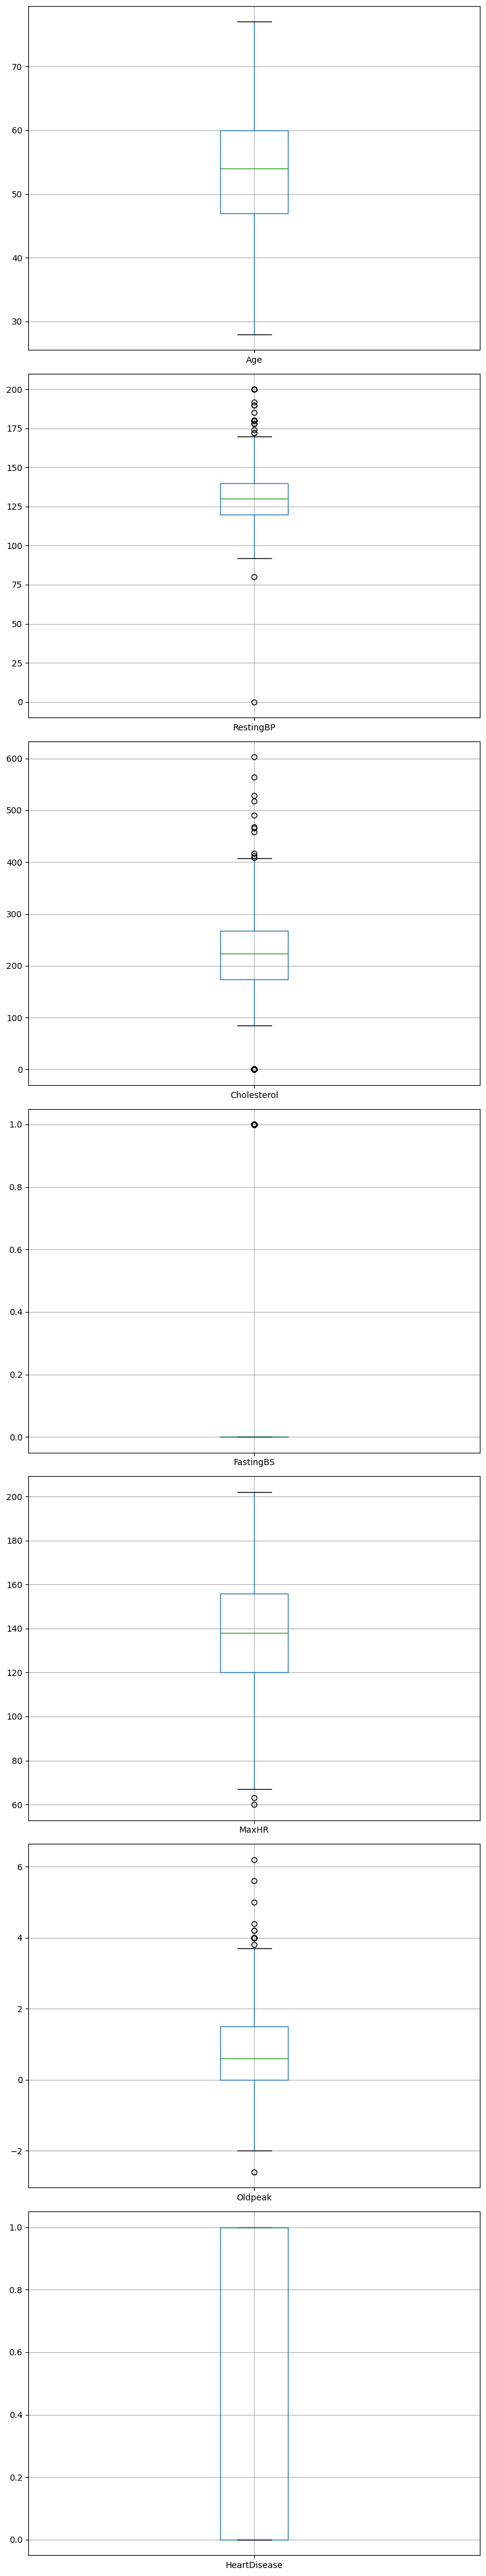

In [ ]:
num_columns = len(data_notobject.columns)

fig, axes = plt.subplots(num_columns, 1, figsize=(8, 6*num_columns))

for i, column in enumerate(data_notobject.columns):
    # Вывожу boxplot для каждого нового столбца
    data_notobject.boxplot(column=column, ax=axes[i])

plt.tight_layout()
plt.show()

Поскольку я не врач и в целом не специалист в этой области, сложно сказать что-то про анамалии в данных. Но одно наблюдение есть. На графике RestingBP - а это кровянное давление в состоянии покоя, есть точка (точки) со значением равным 0. Что представляется крайнемаловероятным в реальной жизни. Посмотрю сколько таких строк в данных.

In [ ]:
data[data['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


На мой взляд это все-таки аномальное значение и я удалю эту строку из данных. С остальными выбросами смирюсь как неспециалист в области сердечных заболеваний.

In [ ]:
data = data[data['RestingBP'] != 0]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 917 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             917 non-null    int64  
 1   Sex             917 non-null    object 
 2   ChestPainType   917 non-null    object 
 3   RestingBP       917 non-null    int64  
 4   Cholesterol     917 non-null    int64  
 5   FastingBS       917 non-null    int64  
 6   RestingECG      917 non-null    object 
 7   MaxHR           917 non-null    int64  
 8   ExerciseAngina  917 non-null    object 
 9   Oldpeak         917 non-null    float64
 10  ST_Slope        917 non-null    object 
 11  HeartDisease    917 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 93.1+ KB


Преобразуем категориальный признаки. Если уникальных значений в столбец 2 - используем LabelEncoder, если больше 2 - применяем pd.get_dummies.

In [ ]:
# Выведу в список название столбцов с типом данных onject
columns_list_2 = data_object.columns.tolist()

In [ ]:
le = LabelEncoder()

In [ ]:
# Если количество уникальных значений в столбце = 2 применяю LabelEncoder, если больше 2 - применяю pd.get_dummies, через дополнительный список
columns = []
for i in columns_list_2:
  if len(data[i].unique()) == 2:
    data[i] = le.fit_transform(data[i])
  if len(data[i].unique()) > 2:
    columns.append(i)
data = pd.get_dummies(data, columns = columns)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 917 entries, 0 to 917
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                917 non-null    int64  
 1   Sex                917 non-null    int64  
 2   RestingBP          917 non-null    int64  
 3   Cholesterol        917 non-null    int64  
 4   FastingBS          917 non-null    int64  
 5   MaxHR              917 non-null    int64  
 6   ExerciseAngina     917 non-null    int64  
 7   Oldpeak            917 non-null    float64
 8   HeartDisease       917 non-null    int64  
 9   ChestPainType_ASY  917 non-null    uint8  
 10  ChestPainType_ATA  917 non-null    uint8  
 11  ChestPainType_NAP  917 non-null    uint8  
 12  ChestPainType_TA   917 non-null    uint8  
 13  RestingECG_LVH     917 non-null    uint8  
 14  RestingECG_Normal  917 non-null    uint8  
 15  RestingECG_ST      917 non-null    uint8  
 16  ST_Slope_Down      917 non

3. Разделите выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое.

In [ ]:
# Разделим датафрейм на признаки и целевую переменную
X = data.loc[:, data.columns !='HeartDisease']
y = data['HeartDisease']

In [ ]:
# Деление выборки на обучающее и тестовое множество
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 9)

4. Обучите модель логистической регрессии с параметрами по умолчанию.

In [ ]:
# Инициализация модели с параметрами по-умолчанию
model_1 = LogisticRegression(random_state = 9)

In [ ]:
# Обучение модели
model_1.fit(X_train, y_train)

LogisticRegression(random_state=9)

5. Подсчитайте основные метрики модели.

In [ ]:
# Посчитаем основные метрики
scores_1 = cross_validate(model_1, X_train, y_train, cv = 10, scoring = ['accuracy', 'recall', 'precision', 'f1'])
scores_1

{'fit_time': array([0.11695099, 0.12268972, 0.07886553, 0.06747389, 0.06603003,
        0.09438825, 0.10873127, 0.14781713, 0.0527451 , 0.0590713 ]),
 'score_time': array([0.02923727, 0.02176476, 0.02786279, 0.02286768, 0.02029634,
        0.01563978, 0.02832055, 0.01007414, 0.01867604, 0.01960921]),
 'test_accuracy': array([0.89189189, 0.89189189, 0.86486486, 0.83561644, 0.76712329,
        0.82191781, 0.87671233, 0.83561644, 0.89041096, 0.83561644]),
 'test_recall': array([0.97560976, 0.95121951, 0.82926829, 0.87804878, 0.75609756,
        0.90243902, 0.90243902, 0.875     , 0.925     , 0.875     ]),
 'test_precision': array([0.85106383, 0.86666667, 0.91891892, 0.8372093 , 0.81578947,
        0.80434783, 0.88095238, 0.83333333, 0.88095238, 0.83333333]),
 'test_f1': array([0.90909091, 0.90697674, 0.87179487, 0.85714286, 0.78481013,
        0.85057471, 0.89156627, 0.85365854, 0.90243902, 0.85365854])}

In [ ]:
# Создам датафрейм с параметрами метрик, которые буду использовать на протяжении всего задания, добавляя туда новые показатели
data_metrics = pd.DataFrame(columns=list(scores_1.keys()))
# Добавлю столбец для названия модели
data_metrics.insert(loc = 0, column='model/metrics', value = '')
# Создам список с посчитанными выше метриками и заполню его
metrics = ['LogisticRegression_default']
for j in list(scores_1.keys()):
  metrics.append(round(scores_1[j].mean(), 4))
# Добавлю строку в датафрейм
data_metrics.loc[len(data_metrics.index)] = metrics
data_metrics

,model/metrics,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1
0,LogisticRegression_default,0.0915,0.0214,0.8512,0.887,0.8523,0.8682


6. Оптимизируем 3-4 параметра модели.

6.1. С помощью GridSearchCV.

In [ ]:
# Параметры для оптимизации
p1 = [200, 400, 1000] # для параметра max_iter
p2 = [1e-3, 1e-4, 1e-6] # для параметра tol
p3 = ['lnewton-cg', 'sag', 'liblinear'] # для параметра solver

params = {'max_iter' : p1, 'tol' : p2, 'solver' : p3}

In [ ]:
# Инициализация модели
model_2 = LogisticRegression(random_state = 9)
model_GSCV = GridSearchCV(model_2, params, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)

In [ ]:
# Перебор параметров
model_GSCV.fit(X_train, y_train)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=9), n_jobs=-1,
             param_grid={'max_iter': [200, 400, 1000],
                         'solver': ['lnewton-cg', 'sag', 'liblinear'],
                         'tol': [0.001, 0.0001, 1e-06]},
             scoring='accuracy', verbose=1)

In [ ]:
# Лучшее решение
model_GSCV.best_estimator_

LogisticRegression(max_iter=200, random_state=9, solver='liblinear', tol=0.001)

In [ ]:
# Лучший параметр скора
model_GSCV.best_score_

0.8443724546464273

In [ ]:
# Посчитаем основные метрики
scores_2 = cross_validate(model_GSCV, X_train, y_train, cv = 10, scoring = ['accuracy', 'recall', 'precision', 'f1'])
scores_2

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Fitting 10 folds for each of 27 candidates, totalling 270 fits


{'fit_time': array([9.19820762, 9.18151784, 7.85348988, 9.11979079, 9.18971014,
        7.95004797, 9.16152143, 9.24984932, 7.96126962, 9.21124053]),
 'score_time': array([0.00716138, 0.00726295, 0.00747085, 0.00702786, 0.00703502,
        0.00711846, 0.00705814, 0.00707316, 0.00701284, 0.00708079]),
 'test_accuracy': array([0.89189189, 0.86486486, 0.85135135, 0.84931507, 0.78082192,
        0.83561644, 0.87671233, 0.79452055, 0.87671233, 0.82191781]),
 'test_recall': array([0.97560976, 0.90243902, 0.80487805, 0.87804878, 0.7804878 ,
        0.92682927, 0.90243902, 0.825     , 0.9       , 0.875     ]),
 'test_precision': array([0.85106383, 0.86046512, 0.91666667, 0.85714286, 0.82051282,
        0.80851064, 0.88095238, 0.80487805, 0.87804878, 0.81395349]),
 'test_f1': array([0.90909091, 0.88095238, 0.85714286, 0.86746988, 0.8       ,
        0.86363636, 0.89156627, 0.81481481, 0.88888889, 0.84337349])}

In [ ]:
# Создам список с посчитанными выше метриками и заполню его
metrics_2 = ['LogisticRegression_default + GridSearchCV']
for j in list(scores_2.keys()):
  metrics_2.append(round(scores_2[j].mean(), 4))
# Добавлю строку в датафрейм
data_metrics.loc[len(data_metrics.index)] = metrics_2
data_metrics

,model/metrics,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1
0,LogisticRegression_default,0.0915,0.0214,0.8512,0.8870,0.8523,0.8682
1,LogisticRegression_default + GridSearchCV,8.8077,0.0071,0.8444,0.8771,0.8492,0.8617


6.2. С помощью RandomizedSearchCV.

In [ ]:
# Инициализация модели
model_3 = LogisticRegression(random_state = 9)
model_RSCV = RandomizedSearchCV(model_3, params, cv=10, scoring='accuracy', n_jobs=-1, verbose=1, n_iter = 20)

In [ ]:
# Перебор параметров
model_RSCV.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=10, estimator=LogisticRegression(random_state=9),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_iter': [200, 400, 1000],
                                        'solver': ['lnewton-cg', 'sag',
                                                   'liblinear'],
                                        'tol': [0.001, 0.0001, 1e-06]},
                   scoring='accuracy', verbose=1)

In [ ]:
# Лучшее решение
model_RSCV.best_estimator_

LogisticRegression(max_iter=200, random_state=9, solver='liblinear')

In [ ]:
# Лучший параметр скора
model_RSCV.best_score_

0.8443724546464273

In [ ]:
# Посчитаем основные метрики
scores_3 = cross_validate(model_RSCV, X_train, y_train, cv = 10, scoring = ['accuracy', 'recall', 'precision', 'f1'])
scores_3

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits


{'fit_time': array([5.19835138, 5.60609269, 6.96260023, 6.48133278, 8.44157147,
        8.28445983, 5.22652745, 5.68187833, 7.46585155, 4.59699869]),
 'score_time': array([0.00678468, 0.01138234, 0.00668645, 0.01099229, 0.00758123,
        0.00693393, 0.00711584, 0.01177502, 0.00687695, 0.010144  ]),
 'test_accuracy': array([0.89189189, 0.86486486, 0.85135135, 0.84931507, 0.78082192,
        0.83561644, 0.87671233, 0.79452055, 0.87671233, 0.82191781]),
 'test_recall': array([0.97560976, 0.90243902, 0.80487805, 0.87804878, 0.7804878 ,
        0.92682927, 0.90243902, 0.825     , 0.9       , 0.875     ]),
 'test_precision': array([0.85106383, 0.86046512, 0.91666667, 0.85714286, 0.82051282,
        0.80851064, 0.88095238, 0.80487805, 0.87804878, 0.81395349]),
 'test_f1': array([0.90909091, 0.88095238, 0.85714286, 0.86746988, 0.8       ,
        0.86363636, 0.89156627, 0.81481481, 0.88888889, 0.84337349])}

In [ ]:
# Создам список с посчитанными выше метриками и заполню его
metrics_3 = ['LogisticRegression_default + RandomizedSearchCV']
for j in list(scores_3.keys()):
  metrics_3.append(round(scores_3[j].mean(), 4))
# Добавлю строку в датафрейм
data_metrics.loc[len(data_metrics.index)] = metrics_3
data_metrics

,model/metrics,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1
0,LogisticRegression_default,0.0915,0.0214,0.8512,0.8870,0.8523,0.8682
1,LogisticRegression_default + GridSearchCV,8.8077,0.0071,0.8444,0.8771,0.8492,0.8617
2,LogisticRegression_default + RandomizedSearchCV,6.3946,0.0086,0.8444,0.8771,0.8492,0.8617


6.3. С помощью RandomizedSearchCV, несколько моделей

In [ ]:
# Инициализируем модели
model_DT = DecisionTreeClassifier(random_state = 9)
model_RF = RandomForestClassifier(random_state = 9)

In [ ]:
# Задаем параетры стекинга и инициализируем его
estimators = [('DT', model_DT), ('RF', model_RF)]
model_st = StackingClassifier(estimators = estimators)

In [ ]:
# Задаем словари параметров для подбора оптимальных
params_list = {'DT__criterion' : ['gini', 'entropy', 'log_loss'],
               'DT__max_depth': [50, 100, 150],
               'DT__min_samples_split' : [2, 4, 6],
               'RF__n_estimators' : [200, 400, 600],
               'RF__criterion' : ['gini', 'entropy', 'log_loss'],
               'RF__max_depth': [50, 100, 150]}

In [ ]:
# Инициализация модели
model_stacking = RandomizedSearchCV(model_st, params_list, cv=10, scoring='accuracy', verbose=1, n_iter = 20)

In [ ]:
# Обучаем модель
model_stacking.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=10,
                   estimator=StackingClassifier(estimators=[('DT',
                                                             DecisionTreeClassifier(random_state=9)),
                                                            ('RF',
                                                             RandomForestClassifier(random_state=9))]),
                   n_iter=20,
                   param_distributions={'DT__criterion': ['gini', 'entropy',
                                                          'log_loss'],
                                        'DT__max_depth': [50, 100, 150],
                                        'DT__min_samples_split': [2, 4, 6],
                                        'RF__criterion': ['gini', 'entropy',
                                                          'log_loss'],
                                        'RF__max_depth': [50, 100, 150],
                                        'RF__n_estimators': [200, 400, 600]},
                   scoring='accuracy', verbose=1)

In [ ]:
# Лучшее решение
model_stacking.best_estimator_

StackingClassifier(estimators=[('DT',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=150,
                                                       random_state=9)),
                               ('RF',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=150,
                                                       n_estimators=400,
                                                       random_state=9))])

In [ ]:
# Лучший параметр скора
model_stacking.best_score_

0.8675860792299149

In [ ]:
# Посчитаем основные метрики
scores_4 = cross_validate(model_stacking, X_train, y_train, cv = 10, scoring = ['accuracy', 'recall', 'precision', 'f1'])
scores_4

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Fitting 10 folds for each of 20 candidates, totalling 200 fits


{'fit_time': array([ 822.62485194,  991.32056379, 1102.22515917,  960.25157976,
         996.8449409 ,  994.06621885, 1038.12066007, 1008.21960235,
         944.21156192,  978.97528863]),
 'score_time': array([0.04075813, 0.02215862, 0.02012587, 0.05451131, 0.04336047,
        0.03216171, 0.04542565, 0.03592277, 0.02023125, 0.03517175]),
 'test_accuracy': array([0.87837838, 0.89189189, 0.90540541, 0.90410959, 0.78082192,
        0.84931507, 0.84931507, 0.79452055, 0.87671233, 0.87671233]),
 'test_recall': array([0.92682927, 0.92682927, 0.95121951, 0.92682927, 0.80487805,
        0.95121951, 0.85365854, 0.825     , 0.9       , 0.875     ]),
 'test_precision': array([0.86363636, 0.88372093, 0.88636364, 0.9047619 , 0.80487805,
        0.8125    , 0.875     , 0.80487805, 0.87804878, 0.8974359 ]),
 'test_f1': array([0.89411765, 0.9047619 , 0.91764706, 0.91566265, 0.80487805,
        0.87640449, 0.86419753, 0.81481481, 0.88888889, 0.88607595])}

In [ ]:
# Добавим в общую табблицу
metrics_4 = ['Stacking_model: RanmovForest + DecisionTree']
for j in list(scores_4.keys()):
  metrics_4.append(round(scores_4[j].mean(), 4))
# Добавлю строку в датафрейм
data_metrics.loc[len(data_metrics.index)] = metrics_4
data_metrics

,model/metrics,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1
0,LogisticRegression_default,0.0915,0.0214,0.8512,0.8870,0.8523,0.8682
1,LogisticRegression_default + GridSearchCV,8.8077,0.0071,0.8444,0.8771,0.8492,0.8617
2,LogisticRegression_default + RandomizedSearchCV,6.3946,0.0086,0.8444,0.8771,0.8492,0.8617
3,Stacking_model: RanmovForest + DecisionTree,983.6860,0.0350,0.8607,0.8941,0.8611,0.8767


Выводы:
* в ходе работы была проведена работа по оптимизации параметров моделей с помощью GridSearchCV и RandomizedSearchCV;
* по какой-то причине, метрики при подборе параметров практически не изменились по сравнению с использованием параметров модели LogisticRegression по-умолчанию; возможно это как-то связано с простотой даной модели, одни словом, на оптимизацию параметров было затрачено ощутимо больше времени, чем с параметрами по-умолчанию, а результат такой же, даже чуть хуже, в третьем знаке после запятой;
* что касается применения стэкинга двух моделей, я использовал RandomForest и DecisionTree, метрика стала чуть лучше, совсем немного, при этом время обучения и расчета метрик колосальное;
* что касается сравнение показателей с решением задачи в разделе ансамблирование, метрика чуть хуже, чем была полученя там (0,88); но при решении той задачи я использовал три модели в ансамбле, а тут только две; при использовании в этой задачи трех моеделей, время оптимизации видимо было бы еще больше.